# AI Skill Intensity × Wages (CES) — End-to-End Pipeline

This notebook combines the full workflow you built:

1. **Fetch CES monthly average hourly earnings** (BLS API) for major industry supersectors (2022–2025).
2. **Compute SOC-level AI familiarity score** from **O\*NET Technology Skills** using embeddings + cosine similarity (contrastive vs industrial automation).
3. **Bridge SOC → Industry** using **OEWS “All Data”** (occupation-by-industry employment weights) to get **industry AI intensity**.
4. **Merge AI intensity into CES wages** and **standardize (z-score)** the industry AI intensity for analysis.

---

## Files you need on disk

### Required
- `all_data_M_2024.csv` (OEWS “All Data” national file — you already have this)
- `onet_db/Technology Skills.txt` (O\*NET database download)
- *(Optional but recommended)* `onet_db/Occupation Data.txt` (for SOC titles)

### Outputs produced by this notebook
- `ces_hourly_earnings_2022_2025.csv`
- `soc_ai_similarity.csv`
- `ai_intensity_by_naics2.csv`
- `ai_intensity_by_ces_bucket.csv`
- `ai_intensity_by_ces_bucket_scaled.csv`
- `ces_wages_with_ai_intensity.csv`


In [12]:
# =========================
# 0) Imports + Configuration
# =========================
import os
import re
from pathlib import Path
import numpy as np
import pandas as pd

# CES (BLS API)
import requests
from datetime import datetime

# SOC AI scoring (embeddings)
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# ---- Paths (edit if needed) ----
ONET_DIR = Path("onet_db")                 # folder with O*NET .txt files
OEWS_PATH = Path("all_data_M_2024.csv")    # OEWS all data file

# Outputs
CES_OUT = Path("ces_hourly_earnings_2022_2025.csv")
SOC_AI_OUT = Path("soc_ai_similarity.csv")
AI_BY_NAICS_OUT = Path("ai_intensity_by_naics2.csv")
AI_BY_CES_OUT = Path("ai_intensity_by_ces_bucket.csv")
AI_BY_CES_SCALED_OUT = Path("ai_intensity_by_ces_bucket_scaled.csv")
PANEL_OUT = Path("ces_wages_with_ai_intensity.csv")

# If you have a BLS API key, put it here or set env var BLS_API_KEY
BLS_API_KEY = os.getenv("BLS_API_KEY", None)

print("Setup complete.")

c:\Users\ammsh\Desktop\SMU Capstone\code 3\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete.


## 1) Fetch CES monthly average hourly earnings (BLS API)

This pulls monthly **average hourly earnings** for Total Private and major supersectors.
You can run without a key, but a key increases rate limits.


In [13]:
# =========================
# 1) CES Hourly Earnings Fetch
# =========================
BLS_API_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

# CES Series IDs for Average Hourly Earnings (datatype code 03)
SERIES_IDS = {
    "CES5000000003": "Information",
    "CES6000000003": "Professional & Business Services",
    "CES5500000003": "Financial Activities",
    "CES6500000003": "Education & Health Services",
    "CES7000000003": "Leisure & Hospitality",
    "CES4200000003": "Retail Trade",
    "CES3000000003": "Manufacturing",
    "CES2000000003": "Construction",
    "CES1000000003": "Mining & Logging",
}

def fetch_bls_data(series_ids, start_year=2022, end_year=2025, api_key=None):
    headers = {"Content-type": "application/json"}
    payload = {"seriesid": list(series_ids), "startyear": str(start_year), "endyear": str(end_year)}
    if api_key:
        payload["registrationkey"] = api_key
    r = requests.post(BLS_API_URL, json=payload, headers=headers)
    r.raise_for_status()
    return r.json()

def parse_bls_response(response, series_mapping):
    if response.get("status") != "REQUEST_SUCCEEDED":
        raise ValueError(f"BLS API request failed: {response.get('message', 'Unknown error')}")
    records = []
    for series in response.get("Results", {}).get("series", []):
        sid = series.get("seriesID")
        industry = series_mapping.get(sid, sid)
        for obs in series.get("data", []):
            year = int(obs["year"])
            month = int(obs["period"].replace("M", ""))
            if month > 12:
                continue
            records.append({
                "date": datetime(year, month, 1),
                "industry": industry,
                "avg_hourly_earnings": float(obs["value"]),
            })
    df = pd.DataFrame(records).sort_values(["date","industry"]).reset_index(drop=True)
    return df

def get_ces_hourly_earnings(start_year=2022, end_year=2025, api_key=None):
    resp = fetch_bls_data(SERIES_IDS.keys(), start_year=start_year, end_year=end_year, api_key=api_key)
    df = parse_bls_response(resp, SERIES_IDS)
    return df

# Run fetch
ces_df = get_ces_hourly_earnings(start_year=2022, end_year=2025, api_key=BLS_API_KEY)
ces_df.to_csv(CES_OUT, index=False)
print(f"Wrote {CES_OUT} with {len(ces_df):,} rows")
ces_df.head(10)

Wrote ces_hourly_earnings_2022_2025.csv with 432 rows


,date,industry,avg_hourly_earnings
0,2022-01-01,Construction,33.83
1,2022-01-01,Education & Health Services,31.27
2,2022-01-01,Financial Activities,40.86
3,2022-01-01,Information,45.09
4,2022-01-01,Leisure & Hospitality,19.46
5,2022-01-01,Manufacturing,30.53
6,2022-01-01,Mining & Logging,35.31
7,2022-01-01,Professional & Business Services,37.88
8,2022-01-01,Retail Trade,22.57
9,2022-02-01,Construction,33.96


## 2) Build SOC-level AI familiarity score from O\*NET (Technology Skills)

We compute a SOC score based on row-level technology skills text, using:
- **AI anchor text** (positive)
- **Industrial automation anchor text** (negative)

For each SOC, we take the **mean of the top-K row scores** to emphasize the most AI-relevant items for that occupation.


In [14]:
# =========================
# 2) SOC AI Similarity (Contrastive, Top-K)
# =========================
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
TOP_K = 5

AI_ANCHOR_TEXT = """artificial intelligence systems
machine learning models
predictive analytics software
decision support systems
recommendation systems
automation of cognitive tasks
intelligent software tools
AI-powered applications
model outputs interpretation
human-in-the-loop AI
algorithmic decision making
data-driven automation
AI workflow integration
AI system configuration
AI-assisted analysis
AI tooling
"""

AUTOMATION_ANCHOR_TEXT = """industrial automation manufacturing assembly line production process machine operation
equipment monitoring numerical control cnc plc scada control systems plant operations
quality inspection conveyor packaging machining welding forklift warehouse
"""

SOC_PATTERN = re.compile(r"^\d{2}-\d{4}\.\d{2}$|^\d{2}-\d{4}$")

def read_onet_table(path: Path) -> pd.DataFrame:
    for sep in ["\t", ","]:
        try:
            df = pd.read_csv(path, sep=sep, dtype=str, engine="python")
            if df.shape[1] >= 2:
                df.columns = [c.strip() for c in df.columns]
                return df
        except Exception:
            pass
    raise RuntimeError(f"Could not parse {path.name}")

def find_soc_col(df: pd.DataFrame) -> str:
    for c in ["O*NET-SOC Code","ONET-SOC Code","O_NET-SOC Code"]:
        if c in df.columns:
            return c
    for c in df.columns:
        if "SOC" in c.upper() and "CODE" in c.upper():
            return c
    raise RuntimeError("SOC code column not found")

def normalize_soc_to_2018(onet_soc: str) -> str:
    return str(onet_soc).split(".")[0].strip()

def clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", str(s)).strip()

def load_titles(onet_dir: Path) -> pd.DataFrame:
    f = onet_dir / "Occupation Data.txt"
    if not f.exists():
        return pd.DataFrame(columns=["onet_soc_code","title"])
    df = read_onet_table(f)
    soc_col = find_soc_col(df)
    title_col = "Title" if "Title" in df.columns else None
    if not title_col:
        return pd.DataFrame(columns=["onet_soc_code","title"])
    out = df[[soc_col, title_col]].copy()
    out.columns = ["onet_soc_code","title"]
    out["onet_soc_code"] = out["onet_soc_code"].astype(str).str.strip()
    out["title"] = out["title"].astype(str).str.strip()
    return out.drop_duplicates("onet_soc_code")

tech_file = ONET_DIR / "Technology Skills.txt"
if not tech_file.exists():
    raise FileNotFoundError(f"Missing {tech_file}. Put Technology Skills.txt in {ONET_DIR}/")

tech = read_onet_table(tech_file)
soc_col = find_soc_col(tech)

text_cols = [c for c in ["Technology Skill","Title","Commodity Title","Description","Example"] if c in tech.columns]
if not text_cols:
    text_cols = [c for c in tech.columns if "id" not in c.lower() and "code" not in c.lower()][:4]

tech = tech[[soc_col] + text_cols].copy().rename(columns={soc_col: "onet_soc_code"})
tech["onet_soc_code"] = tech["onet_soc_code"].astype(str).str.strip()
tech = tech[tech["onet_soc_code"].apply(lambda x: bool(SOC_PATTERN.match(x)))]

tech["row_text"] = tech[text_cols].astype(str).agg(" | ".join, axis=1).map(clean_text)
tech = tech[tech["row_text"].str.len() > 0].reset_index(drop=True)

print("Rows in Technology Skills:", len(tech))
print("Unique SOC codes:", tech["onet_soc_code"].nunique())

model = SentenceTransformer(MODEL_NAME)
ai_emb = model.encode([AI_ANCHOR_TEXT], normalize_embeddings=True)
auto_emb = model.encode([AUTOMATION_ANCHOR_TEXT], normalize_embeddings=True)

row_emb = model.encode(tech["row_text"].tolist(), normalize_embeddings=True, show_progress_bar=True)

ai_sim = cosine_similarity(row_emb, ai_emb).ravel()
auto_sim = cosine_similarity(row_emb, auto_emb).ravel()

tech["ai_sim_raw"] = ai_sim
tech["automation_sim_raw"] = auto_sim
tech["ai_exposure_row"] = tech["ai_sim_raw"] - np.maximum(tech["automation_sim_raw"], 0.0)

def topk_mean(x: pd.Series, k: int) -> float:
    if len(x) == 0:
        return np.nan
    return float(np.mean(np.sort(x.values)[-min(k, len(x)):]))  # mean of top-K

soc_ai = tech.groupby("onet_soc_code").agg(
    ai_exposure=("ai_exposure_row", lambda s: topk_mean(s, TOP_K)),
    ai_sim_raw=("ai_sim_raw", lambda s: topk_mean(s, TOP_K)),
    automation_sim_raw=("automation_sim_raw", lambda s: topk_mean(s, TOP_K)),
    n_rows_used=("ai_exposure_row", "size")
).reset_index()

soc_ai["soc_2018"] = soc_ai["onet_soc_code"].map(normalize_soc_to_2018)

titles = load_titles(ONET_DIR)
soc_ai = soc_ai.merge(titles, on="onet_soc_code", how="left")
soc_ai["title"] = soc_ai["title"].fillna("Unknown")

soc_ai.to_csv(SOC_AI_OUT, index=False)
print(f"Wrote {SOC_AI_OUT} with {len(soc_ai):,} SOC rows")

soc_ai.sort_values("ai_exposure", ascending=False).head(10)

Rows in Technology Skills: 32773
Unique SOC codes: 923


Batches: 100%|██████████| 1025/1025 [00:29<00:00, 35.21it/s]


Wrote soc_ai_similarity.csv with 923 SOC rows


,onet_soc_code,ai_exposure,ai_sim_raw,automation_sim_raw,n_rows_used,soc_2018,title
117,15-1252.00,0.312766,0.435466,0.312582,429,15-1252,Software Developers
137,15-2051.01,0.307303,0.447538,0.313379,202,15-2051,Business Intelligence Analysts
107,15-1221.00,0.306578,0.445552,0.312671,163,15-1221,Computer and Information Research Scientists
113,15-1243.00,0.294625,0.443494,0.346019,324,15-1243,Database Architects
82,13-1161.00,0.292378,0.461576,0.289457,150,13-1161,Market Research Analysts and Marketing Special...
112,15-1242.00,0.289266,0.434264,0.401845,288,15-1242,Database Administrators
96,13-2054.00,0.285956,0.449204,0.277498,189,13-2054,Financial Risk Specialists
93,13-2051.00,0.285909,0.457172,0.277498,181,13-2051,Financial and Investment Analysts
498,33-3021.06,0.282560,0.428917,0.298776,84,33-3021,Intelligence Analysts
136,15-2051.00,0.279702,0.427793,0.291339,87,15-2051,Data Scientists


## 3) Bridge SOC → Industry using OEWS employment weights

We map SOC AI scores into industries using OEWS employment counts:
- Convert OEWS `NAICS` to **2-digit NAICS**
- Merge OEWS rows with SOC AI score by SOC code
- Compute **employment-weighted AI intensity** by NAICS2
- Aggregate NAICS2 into CES supersector buckets
- Merge into CES monthly wages panel

Note: This version **excludes government** in the CES panel.


In [20]:
# =========================
# 3) OEWS → NAICS2 → CES bucket AI intensity + merge into CES wages
# =========================
CES_BUCKET_TO_NAICS2 = {
    "information": {"51"},
    "financial_activities": {"52", "53"},
    "professional_business_services": {"54", "55", "56"},
    "education_health": {"61", "62"},
    "leisure_hospitality": {"71", "72"},
    "trade_transportation_utilities": {"42", "44", "45", "48", "49", "22"},
    "manufacturing": {"31", "32", "33"},
    "construction": {"23"},
    "mining_logging": {"21"},
    "other_services": {"81"},
}

INDUSTRY_TO_BUCKET = {
    "Information": "information",
    "Financial Activities": "financial_activities",
    "Professional & Business Services": "professional_business_services",
    "Education & Health Services": "education_health",
    "Leisure & Hospitality": "leisure_hospitality",
    "Retail Trade": "trade_transportation_utilities",
    "Manufacturing": "manufacturing",
    "Construction": "construction",
    "Mining & Logging": "mining_logging",
    "Other Services": "other_services",
    "Total Private": "total_private",
}

def normalize_soc_simple(s: str) -> str:
    if pd.isna(s):
        return None
    s = str(s).strip()
    return s.split(".")[0]

def normalize_naics2(n: str) -> str:
    if pd.isna(n):
        return None
    n = str(n).strip()
    if "-" in n:
        return None
    digits = re.sub(r"\D", "", n)
    if len(digits) >= 2:
        return digits[:2]
    return None

def safe_float(x):
    try:
        return float(str(x).replace(",", "").strip())
    except Exception:
        return np.nan

# Load SOC AI scores
soc = pd.read_csv(SOC_AI_OUT)
soc["soc_code"] = soc["soc_2018"].astype(str).map(normalize_soc_simple)
soc = soc[["soc_code", "ai_exposure"]].dropna()
soc = soc[soc["soc_code"].str.match(r"^\d{2}-\d{4}$")].copy()

# Load OEWS
oews = pd.read_csv(OEWS_PATH, dtype=str)

for col in ["NAICS", "OCC_CODE", "TOT_EMP"]:
    if col not in oews.columns:
        raise ValueError(f"OEWS missing {col}. Columns: {list(oews.columns)}")

# Recommended: keep national totals only
if "AREA" in oews.columns:
    oews = oews[oews["AREA"].astype(str).str.strip().eq("99")].copy()
    print("OEWS filtered to AREA==99 (national). Rows:", len(oews))

oews["soc_code"] = oews["OCC_CODE"].map(normalize_soc_simple)
oews["naics2"] = oews["NAICS"].map(normalize_naics2)
oews["emp"] = oews["TOT_EMP"].map(safe_float)

oews = oews.dropna(subset=["soc_code","naics2","emp"])
oews = oews[(oews["emp"] > 0) & (oews["soc_code"].str.match(r"^\d{2}-\d{4}$"))].copy()

# Merge OEWS × SOC AI
m = oews.merge(soc, on="soc_code", how="inner")
print("OEWS×SOC merged rows:", len(m))

# AI intensity by NAICS2
ai_by_naics2 = (
    m.groupby("naics2")
     .apply(lambda g: np.average(g["ai_exposure"], weights=g["emp"]))
     .reset_index(name="ai_intensity")
)
emp_by_naics2 = m.groupby("naics2")["emp"].sum().reset_index(name="emp_total")
ai_by_naics2 = ai_by_naics2.merge(emp_by_naics2, on="naics2", how="left")
ai_by_naics2.to_csv(AI_BY_NAICS_OUT, index=False)
print("Wrote", AI_BY_NAICS_OUT)

# NAICS2 → CES buckets
ai_lookup = ai_by_naics2.set_index("naics2")["ai_intensity"].to_dict()
emp_lookup = ai_by_naics2.set_index("naics2")["emp_total"].to_dict()

def bucket_ai(bucket: str):
    if bucket == "total_private":
        naics_list = list(ai_lookup.keys())
    else:
        naics_set = CES_BUCKET_TO_NAICS2.get(bucket)
        if naics_set is None:
            return np.nan
        naics_list = [n for n in naics_set if n in ai_lookup]
    if not naics_list:
        return np.nan
    weights = np.array([emp_lookup[n] for n in naics_list], dtype=float)
    values  = np.array([ai_lookup[n] for n in naics_list], dtype=float)
    if weights.sum() == 0:
        return np.nan
    return float(np.average(values, weights=weights))

ai_by_ces = pd.DataFrame({"industry_bucket": list(CES_BUCKET_TO_NAICS2.keys())})
ai_by_ces["ai_intensity"] = ai_by_ces["industry_bucket"].map(bucket_ai)
ai_by_ces.to_csv(AI_BY_CES_OUT, index=False)
print("Wrote", AI_BY_CES_OUT)

# Merge into CES monthly wages
ces = pd.read_csv(CES_OUT)
ces["industry_bucket"] = ces["industry"].map(INDUSTRY_TO_BUCKET)
ces = ces[ces["industry_bucket"].notna()].copy()
panel = ces.merge(ai_by_ces, on="industry_bucket", how="left")
panel.to_csv(PANEL_OUT, index=False)
print("Wrote", PANEL_OUT)

panel.head(10)

OEWS filtered to AREA==99 (national). Rows: 177824
OEWS×SOC merged rows: 95170
Wrote ai_intensity_by_naics2.csv
Wrote ai_intensity_by_ces_bucket.csv
Wrote ces_wages_with_ai_intensity.csv


C:\Users\ammsh\AppData\Local\Temp\ipykernel_52236\2783056340.py:86: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g["ai_exposure"], weights=g["emp"]))


,date,industry,avg_hourly_earnings,industry_bucket,ai_intensity
0,2022-01-01,Construction,33.83,construction,0.174225
1,2022-01-01,Education & Health Services,31.27,education_health,0.178645
2,2022-01-01,Financial Activities,40.86,financial_activities,0.213001
3,2022-01-01,Information,45.09,information,0.213376
4,2022-01-01,Leisure & Hospitality,19.46,leisure_hospitality,0.135076
5,2022-01-01,Manufacturing,30.53,manufacturing,0.175884
6,2022-01-01,Mining & Logging,35.31,mining_logging,0.171042
7,2022-01-01,Professional & Business Services,37.88,professional_business_services,0.200602
8,2022-01-01,Retail Trade,22.57,trade_transportation_utilities,0.175373
9,2022-02-01,Construction,33.96,construction,0.174225


## 4) Standardize AI intensity (z-score)

Creates `ai_intensity_zscore` so values are comparable across industries.


In [21]:
# =========================
# 4) Z-score standardization of AI intensity by CES bucket
# =========================
ai = pd.read_csv(AI_BY_CES_OUT)

mean_val = ai["ai_intensity"].mean()
std_val = ai["ai_intensity"].std()

ai["ai_intensity_zscore"] = (ai["ai_intensity"] - mean_val) / std_val
ai.to_csv(AI_BY_CES_SCALED_OUT, index=False)

print("Mean AI intensity:", mean_val)
print("Std Dev AI intensity:", std_val)
print("Wrote", AI_BY_CES_SCALED_OUT)

ai.sort_values("ai_intensity_zscore", ascending=False)

Mean AI intensity: 0.18112938602508974
Std Dev AI intensity: 0.023146490503708383
Wrote ai_intensity_by_ces_bucket_scaled.csv


,industry_bucket,ai_intensity,ai_intensity_zscore
0,information,0.213376,1.393165
1,financial_activities,0.213001,1.376936
2,professional_business_services,0.200602,0.841284
3,education_health,0.178645,-0.107354
6,manufacturing,0.175884,-0.226615
5,trade_transportation_utilities,0.175373,-0.248676
7,construction,0.174225,-0.298288
9,other_services,0.174070,-0.304977
8,mining_logging,0.171042,-0.435818
4,leisure_hospitality,0.135076,-1.989657


## 5) (Optional) Within-industry: top AI-scored occupations by employment share

Pick a NAICS2 sector (e.g., `51` Information, `62` Health Care, `54` Professional services) and see the top AI-scored jobs and their employment shares.


In [22]:
# =========================
# 5) Top AI occupations within a chosen NAICS2 sector (optional)
# =========================
TARGET_NAICS2 = "51"  # change me
TOP_N = 15

def normalize_soc_simple(s: str) -> str:
    if pd.isna(s):
        return None
    s = str(s).strip()
    return s.split(".")[0]

def normalize_naics2(n: str) -> str:
    if pd.isna(n):
        return None
    n = str(n).strip()
    if "-" in n:
        return None
    digits = re.sub(r"\D", "", n)
    if len(digits) >= 2:
        return digits[:2]
    return None

def safe_float(x):
    try:
        return float(str(x).replace(",", "").strip())
    except Exception:
        return np.nan

soc_full = pd.read_csv(SOC_AI_OUT)
soc_full["soc_code"] = soc_full["soc_2018"].astype(str).map(normalize_soc_simple)

oews = pd.read_csv(OEWS_PATH, dtype=str)
if "AREA" in oews.columns:
    oews = oews[oews["AREA"].astype(str).str.strip().eq("99")].copy()

oews["soc_code"] = oews["OCC_CODE"].map(normalize_soc_simple)
oews["naics2"] = oews["NAICS"].map(normalize_naics2)
oews["emp"] = oews["TOT_EMP"].map(safe_float)

oews = oews.dropna(subset=["soc_code","naics2","emp"])
oews = oews[(oews["emp"] > 0) & (oews["soc_code"].str.match(r"^\d{2}-\d{4}$"))].copy()

m2 = oews.merge(soc_full[["soc_code","title","ai_exposure"]], on="soc_code", how="inner")
sector = m2[m2["naics2"] == TARGET_NAICS2].copy()

sector_total = sector["emp"].sum()
sector["emp_share"] = sector["emp"] / sector_total

sector = sector.sort_values(["ai_exposure","emp"], ascending=[False, False])
sector[["naics2","soc_code","title","ai_exposure","emp","emp_share"]].head(TOP_N)

,naics2,soc_code,title,ai_exposure,emp,emp_share
3562,51,15-1252,Software Developers,0.312766,330980.0,0.025127
45227,51,15-1252,Software Developers,0.312766,163830.0,0.012437
45769,51,15-1252,Software Developers,0.312766,154190.0,0.011706
47111,51,15-1252,Software Developers,0.312766,77830.0,0.005909
47305,51,15-1252,Software Developers,0.312766,77830.0,0.005909
47489,51,15-1252,Software Developers,0.312766,47580.0,0.003612
47656,51,15-1252,Software Developers,0.312766,47580.0,0.003612
45941,51,15-1252,Software Developers,0.312766,21580.0,0.001638
46486,51,15-1252,Software Developers,0.312766,21110.0,0.001603
46663,51,15-1252,Software Developers,0.312766,17340.0,0.001316


In [23]:
#!pip install statsmodels
# =========================
# 6) Regression: wages ~ AI intensity + time fixed effects
# =========================
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

# ---- Load panel (monthly wages merged with ai_intensity) ----
panel = pd.read_csv(PANEL_OUT, parse_dates=["date"])

# ---- Merge in z-scored AI intensity (recommended for interpretation) ----
ai_scaled = pd.read_csv(AI_BY_CES_SCALED_OUT)
panel = panel.merge(
    ai_scaled[["industry_bucket", "ai_intensity_zscore"]],
    on="industry_bucket",
    how="left",
    suffixes=("", "_z")
)

# ---- Basic cleaning ----
panel = panel.dropna(subset=["avg_hourly_earnings", "ai_intensity_zscore"]).copy()

# Create year-month fixed effect
panel["ym"] = panel["date"].dt.to_period("M").astype(str)

# Optional: log wages (often nicer)
panel["log_wage"] = np.log(panel["avg_hourly_earnings"])

print("Rows:", len(panel))
print("Industries:", panel["industry_bucket"].nunique())
print("Months:", panel["ym"].nunique())

# ============================================================
# Model A: Levels (avg hourly earnings)
#   wage_it = a + b*AI_i + month_FE_t + e_it
# Note: AI_i is time-invariant across months, so you CANNOT also
# include industry fixed effects (they would absorb AI_i).
# ============================================================

m_levels = smf.ols(
    "avg_hourly_earnings ~ ai_intensity_zscore + C(ym)",
    data=panel
).fit(cov_type="cluster", cov_kwds={"groups": panel["industry_bucket"]})

print("\n=== Model A (Levels) ===")
print(m_levels.summary())

# ============================================================
# Model B: Log wages (interpret b as approx % change per 1 SD AI)
# ============================================================

m_log = smf.ols(
    "log_wage ~ ai_intensity_zscore + C(ym)",
    data=panel
).fit(cov_type="cluster", cov_kwds={"groups": panel["industry_bucket"]})

print("\n=== Model B (Log wages) ===")
print(m_log.summary())

# ============================================================
# Model C (Recommended): Difference-in-differences style
# with post-ChatGPT indicator
#   log(wage_it) = a + b1*AI_i + b2*Post_t + b3*(AI_i*Post_t) + month_FE_t + e_it
# But Post_t is collinear with month_FE_t, so we omit Post_t and
# just interact AI with Post and keep month FE.
# Interpretation: b3 = additional change for higher-AI industries post period.
# ============================================================

# Choose a "post" start. Many people use 2023-01 or 2023-12; pick one and justify.
POST_START = pd.Timestamp("2023-12-01")
panel["post"] = (panel["date"] >= POST_START).astype(int)

m_did = smf.ols(
    "log_wage ~ ai_intensity_zscore*post + C(ym)",
    data=panel
).fit(cov_type="cluster", cov_kwds={"groups": panel["industry_bucket"]})

print("\n=== Model C (AI × Post, Log wages) ===")
print("Post period starts:", POST_START.date())
print(m_did.summary())

# Quick interpretation helper:
b3 = m_did.params.get("ai_intensity_zscore:post", np.nan)
if pd.notna(b3):
    print(f"\nInterpretation: 1 SD higher AI intensity is associated with ~{(np.exp(b3)-1)*100:.2f}% "
          f"additional wage change in the post period (holding month FE).")

Rows: 432
Industries: 9
Months: 48

=== Model A (Levels) ===
                             OLS Regression Results                            
Dep. Variable:     avg_hourly_earnings   R-squared:                       0.762
Model:                             OLS   Adj. R-squared:                  0.732
Method:                  Least Squares   F-statistic:                -4.925e+11
Date:                 Sat, 28 Feb 2026   Prob (F-statistic):               1.00
Time:                         19:25:21   Log-Likelihood:                -1237.5
No. Observations:                  432   AIC:                             2573.
Df Residuals:                      383   BIC:                             2772.
Df Model:                           48                                         
Covariance Type:               cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

c:\Users\ammsh\Desktop\SMU Capstone\code 3\venv\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 48, but rank is 29
  warnings.warn('covariance of constraints does not have full '
c:\Users\ammsh\Desktop\SMU Capstone\code 3\venv\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 48, but rank is 46
  warnings.warn('covariance of constraints does not have full '
c:\Users\ammsh\Desktop\SMU Capstone\code 3\venv\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 50, but rank is 34
  warnings.warn('covariance of constraints does not have full '


In [24]:
# =========================
# 7) Load panel + merge AI z-scores + sanity checks
# =========================
import pandas as pd
import numpy as np

PANEL_PATH = "ces_wages_with_ai_intensity.csv"
AI_SCALED_PATH = "ai_intensity_by_ces_bucket_scaled.csv"

panel = pd.read_csv(PANEL_PATH, parse_dates=["date"])
ai_scaled = pd.read_csv(AI_SCALED_PATH)

panel = panel.merge(
    ai_scaled[["industry_bucket", "ai_intensity_zscore"]],
    on="industry_bucket",
    how="left"
)

panel = panel.dropna(subset=["avg_hourly_earnings", "ai_intensity_zscore"]).copy()
panel["ym"] = panel["date"].dt.to_period("M").astype(str)
panel["log_wage"] = np.log(panel["avg_hourly_earnings"])

print("Rows:", len(panel))
print("Industries:", panel["industry_bucket"].nunique())
print("Months:", panel["ym"].nunique())

# Quick checks
print("\nAI intensity z-score summary:")
print(panel[["ai_intensity_zscore"]].describe())

print("\nMissing AI z-score rows:", panel["ai_intensity_zscore"].isna().sum())
print("\nIndustries (panel):", sorted(panel["industry_bucket"].unique()))

Rows: 432
Industries: 9
Months: 48

AI intensity z-score summary:
       ai_intensity_zscore
count           432.000000
mean              0.033886
std               0.995395
min              -1.989657
25%              -0.298288
50%              -0.226615
75%               0.841284
max               1.393165

Missing AI z-score rows: 0

Industries (panel): ['construction', 'education_health', 'financial_activities', 'information', 'leisure_hospitality', 'manufacturing', 'mining_logging', 'professional_business_services', 'trade_transportation_utilities']


In [25]:
# =========================
# 8) Derive high AI-tool industries: ranking + quantiles
# =========================
rank_tbl = (
    panel[["industry_bucket", "ai_intensity_zscore"]]
    .drop_duplicates()
    .sort_values("ai_intensity_zscore", ascending=False)
    .reset_index(drop=True)
)

rank_tbl["rank"] = np.arange(1, len(rank_tbl) + 1)

# Quantiles (11 industries -> terciles are often more stable than quartiles)
rank_tbl["ai_group_tercile"] = pd.qcut(rank_tbl["ai_intensity_zscore"], 3, labels=["Low", "Mid", "High"])

print(rank_tbl[["rank", "industry_bucket", "ai_intensity_zscore", "ai_group_tercile"]])

# Merge group labels back into panel
panel = panel.merge(rank_tbl[["industry_bucket", "ai_group_tercile"]], on="industry_bucket", how="left")

   rank                 industry_bucket  ai_intensity_zscore ai_group_tercile
0     1                     information             1.393165             High
1     2            financial_activities             1.376936             High
2     3  professional_business_services             0.841284             High
3     4                education_health            -0.107354              Mid
4     5                   manufacturing            -0.226615              Mid
5     6  trade_transportation_utilities            -0.248676              Mid
6     7                    construction            -0.298288              Low
7     8                  mining_logging            -0.435818              Low
8     9             leisure_hospitality            -1.989657              Low


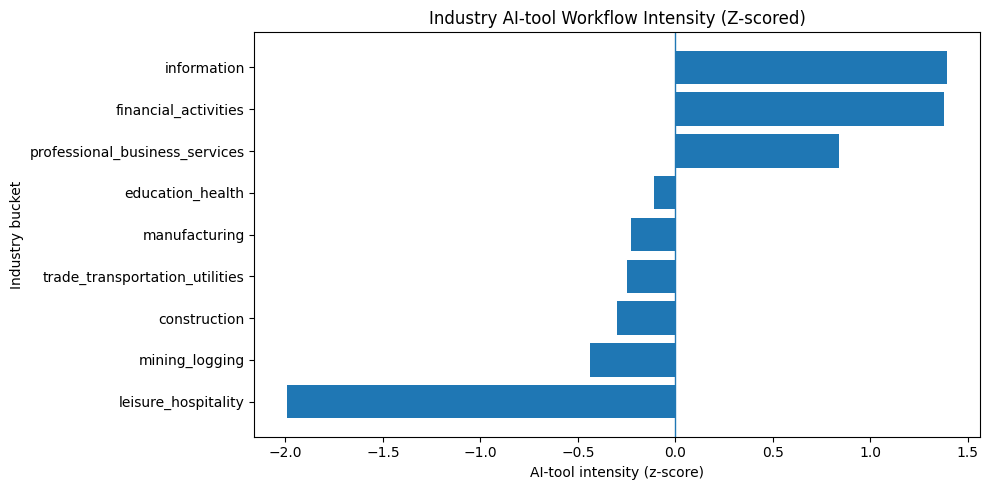

In [ ]:
# =========================
# 9) Figure: AI-tool workflow intensity by industry (z-score)
# =========================
# !pip install matplotlib
import matplotlib.pyplot as plt

plot_tbl = rank_tbl.sort_values("ai_intensity_zscore", ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(plot_tbl["industry_bucket"], plot_tbl["ai_intensity_zscore"])
plt.axvline(0, linewidth=1)
plt.title("Industry AI-tool Workflow Intensity (Z-scored)")
plt.xlabel("AI-tool intensity (z-score)")
plt.ylabel("Industry bucket")
plt.tight_layout()0
plt.show()

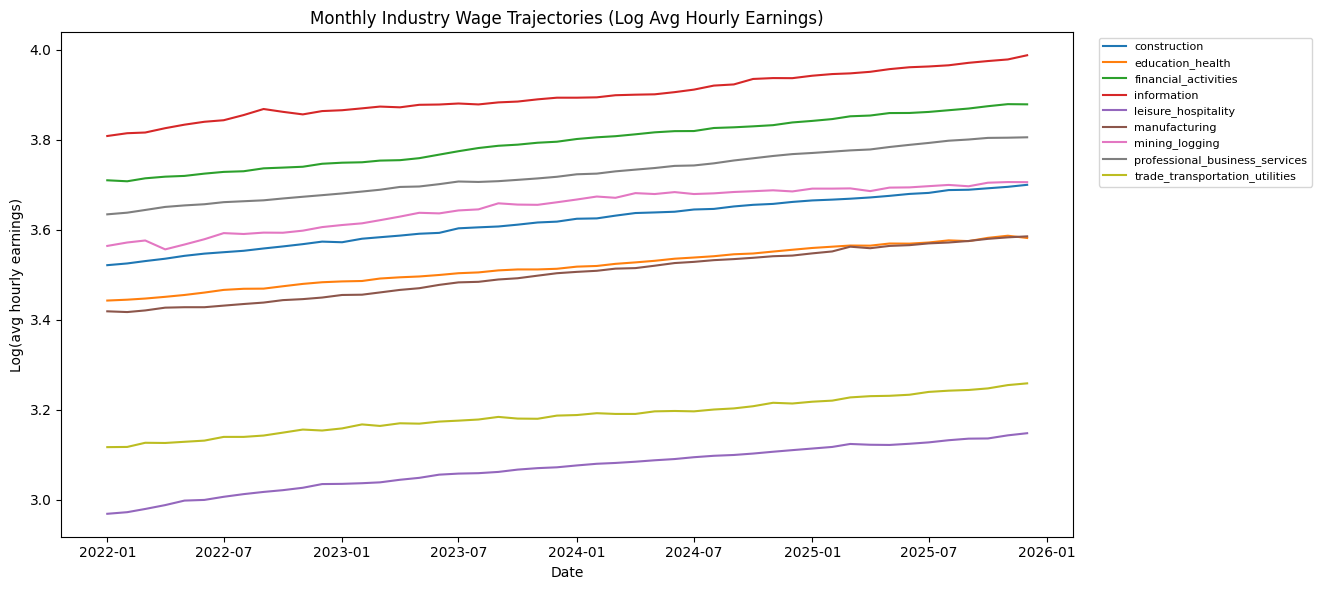

In [28]:
# =========================
# 10) Figure: Wage trajectories by industry (log wages)
# =========================
plt.figure(figsize=(11, 6))
for ind, g in panel.sort_values("date").groupby("industry_bucket"):
    plt.plot(g["date"], g["log_wage"], label=ind)

plt.title("Monthly Industry Wage Trajectories (Log Avg Hourly Earnings)")
plt.xlabel("Date")
plt.ylabel("Log(avg hourly earnings)")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
plt.show()

C:\Users\ammsh\AppData\Local\Temp\ipykernel_52236\1642092084.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel.groupby(["date", "ai_group_tercile"], as_index=False)
C:\Users\ammsh\AppData\Local\Temp\ipykernel_52236\1642092084.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for grp, g in group_series.groupby("ai_group_tercile"):


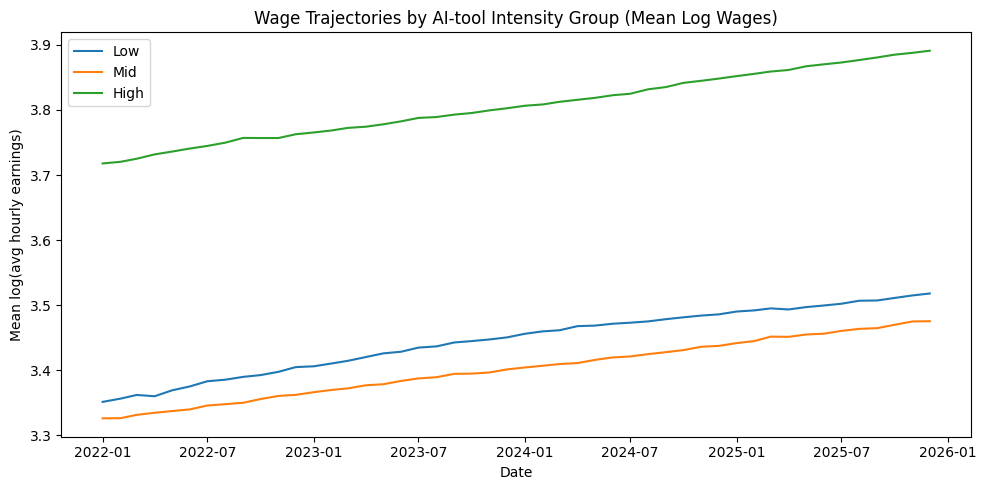

In [29]:
# =========================
# 11) Figure: Wage trajectories by AI intensity group (terciles)
# =========================
group_series = (
    panel.groupby(["date", "ai_group_tercile"], as_index=False)
         .agg(avg_wage=("avg_hourly_earnings", "mean"),
              avg_log_wage=("log_wage", "mean"))
         .sort_values(["ai_group_tercile", "date"])
)

plt.figure(figsize=(10, 5))
for grp, g in group_series.groupby("ai_group_tercile"):
    plt.plot(g["date"], g["avg_log_wage"], label=str(grp))

plt.title("Wage Trajectories by AI-tool Intensity Group (Mean Log Wages)")
plt.xlabel("Date")
plt.ylabel("Mean log(avg hourly earnings)")
plt.tight_layout()
plt.legend()
plt.show()

In [30]:
# =========================
# 12) Pre/Post summary: monthly wage growth by AI group
# =========================
POST_START = pd.Timestamp("2023-12-01")
panel = panel.sort_values(["industry_bucket", "date"]).copy()
panel["post"] = (panel["date"] >= POST_START).astype(int)

# Monthly log changes per industry
panel["dlog_wage"] = panel.groupby("industry_bucket")["log_wage"].diff()

growth_summary = (
    panel.dropna(subset=["dlog_wage"])
         .groupby(["ai_group_tercile", "post"], as_index=False)
         .agg(mean_monthly_log_growth=("dlog_wage", "mean"),
              sd_monthly_log_growth=("dlog_wage", "std"))
)

# Convert mean log growth to approx % per month
growth_summary["mean_monthly_pct"] = (np.exp(growth_summary["mean_monthly_log_growth"]) - 1) * 100

print("Post starts:", POST_START.date())
print(growth_summary.sort_values(["ai_group_tercile", "post"]))

Post starts: 2023-12-01
  ai_group_tercile  post  mean_monthly_log_growth  sd_monthly_log_growth  \
0              Low     0                 0.004363               0.004554   
1              Low     1                 0.002825               0.002857   
2              Mid     0                 0.003206               0.002766   
3              Mid     1                 0.003149               0.002557   
4             High     0                 0.003711               0.003347   
5             High     1                 0.003666               0.002237   

   mean_monthly_pct  
0          0.437205  
1          0.282855  
2          0.321111  
3          0.315442  
4          0.371817  
5          0.367237  


C:\Users\ammsh\AppData\Local\Temp\ipykernel_52236\883763589.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel.dropna(subset=["dlog_wage"])


In [31]:
# =========================
# 13) Regression on wage growth: Δlog(wage) ~ AI intensity + month FE (+ AI×Post)
# =========================
import statsmodels.formula.api as smf

reg = panel.dropna(subset=["dlog_wage", "ai_intensity_zscore"]).copy()

# Model 1: Does AI intensity correlate with monthly wage growth?
m_g1 = smf.ols(
    "dlog_wage ~ ai_intensity_zscore + C(ym)",
    data=reg
).fit(cov_type="cluster", cov_kwds={"groups": reg["industry_bucket"]})

print("\n=== Growth Model 1: Δlog(wage) ~ AI + month FE ===")
print(m_g1.summary())

# Model 2: Does the AI relationship change post period?
m_g2 = smf.ols(
    "dlog_wage ~ ai_intensity_zscore*post + C(ym)",
    data=reg
).fit(cov_type="cluster", cov_kwds={"groups": reg["industry_bucket"]})

print("\n=== Growth Model 2: Δlog(wage) ~ AI×Post + month FE ===")
print("Post period starts:", POST_START.date())
print(m_g2.summary())

b_int = m_g2.params.get("ai_intensity_zscore:post", np.nan)
if pd.notna(b_int):
    print(f"\nInterpretation (growth): 1 SD higher AI intensity is associated with "
          f"{(np.exp(b_int)-1)*100:.4f}% additional monthly wage growth in the post period.")


=== Growth Model 1: Δlog(wage) ~ AI + month FE ===
                            OLS Regression Results                            
Dep. Variable:              dlog_wage   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                    0.4217
Date:                Sat, 28 Feb 2026   Prob (F-statistic):              0.878
Time:                        19:26:43   Log-Likelihood:                 1869.6
No. Observations:                 423   AIC:                            -3643.
Df Residuals:                     375   BIC:                            -3449.
Df Model:                          47                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

c:\Users\ammsh\Desktop\SMU Capstone\code 3\venv\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 8
  warnings.warn('covariance of constraints does not have full '
c:\Users\ammsh\Desktop\SMU Capstone\code 3\venv\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 49, but rank is 8
  warnings.warn('covariance of constraints does not have full '



=== Event Study Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                -1.594e+13
Date:                Sat, 28 Feb 2026   Prob (F-statistic):               1.00
Time:                        19:28:17   Log-Likelihood:                 1556.0
No. Observations:                 432   AIC:                            -2906.
Df Residuals:                     329   BIC:                            -2487.
Df Model:                         102                                         
Covariance Type:              cluster                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

c:\Users\ammsh\Desktop\SMU Capstone\code 3\venv\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 103, but rank is 8
  warnings.warn('covariance of constraints does not have full '


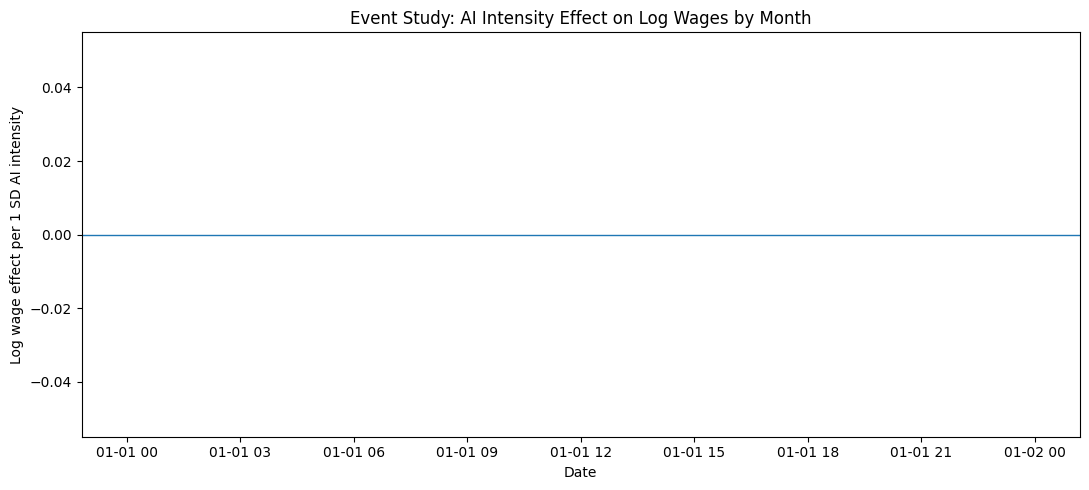


Baseline month omitted from interactions: 2022-01


In [ ]:
# =========================
# 14) Correct Event-Study Specification
# log(wage_it) ~ Industry FE + Month FE + AI_zscore × Month
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Copy panel to avoid mutation
es = panel.copy()

# Ensure month variable is categorical and ordered
es = es.sort_values("date")
es["ym"] = es["date"].dt.to_period("M").astype(str)
es["ym"] = pd.Categorical(es["ym"], categories=sorted(es["ym"].unique()))

# Baseline month (first chronological month)
baseline_month = sorted(es["ym"].unique())[0]

# Run regression with:
# - Industry fixed effects
# - Month fixed effects
# - AI intensity interacted with month dummies
m_es = smf.ols(
    "log_wage ~ C(industry_bucket) + C(ym) + ai_intensity_zscore:C(ym)",
    data=es
).fit(cov_type="cluster", cov_kwds={"groups": es["industry_bucket"]})

print("\n=== Event Study Regression Summary ===")
print(m_es.summary())

# ---------------------------------------
# Extract AI × Month interaction terms
# ---------------------------------------
coefs = m_es.params.filter(like="ai_intensity_zscore:C(ym)")
ses = m_es.bse.filter(like="ai_intensity_zscore:C(ym)")

out = pd.DataFrame({
    "term": coefs.index,
    "coef": coefs.values,
    "se": ses.values
})

# Extract month from parameter names
out["ym"] = out["term"].str.extract(r"C\(ym\)\[T\.(.*)\]")[0]
out = out.dropna(subset=["ym"]).sort_values("ym")

# Convert to datetime for plotting
out["date"] = pd.to_datetime(out["ym"] + "-01")

# 95% confidence intervals
out["lo"] = out["coef"] - 1.96 * out["se"]
out["hi"] = out["coef"] + 1.96 * out["se"]

# ---------------------------------------
# Plot
# ---------------------------------------
plt.figure(figsize=(11, 5))
plt.plot(out["date"], out["coef"])
plt.fill_between(out["date"], out["lo"], out["hi"], alpha=0.25)
plt.axhline(0, linewidth=1)
plt.title("Event Study: AI Intensity Effect on Log Wages by Month")
plt.xlabel("Date")
plt.ylabel("Log wage effect per 1 SD AI intensity")
plt.tight_layout()
plt.show()

print("\nBaseline month omitted from interactions:", baseline_month)